In [1]:
import os
import torch
import numpy as np

import torchvision.transforms as transforms
from datasets import *
from models import *
from displays import *

c:\kht\ai\AI Projects (Local)\proj vision transformer\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading and Preparing Dataset

### Parameters and Settings

In [2]:
IMG_HEI, IMG_WID = 512, 512#160, 320
N_CLASSES = 34
batch_size = 2#128#64

In [3]:
toCuda = lambda x: x.cuda()
G = [
    toCuda,
    #transforms.RandomRotation(degrees=35, 
    #                          interpolation=transforms.InterpolationMode.NEAREST),
    transforms.RandomResizedCrop(size=(IMG_HEI, IMG_WID), scale=(.2, 1), ratio=(4/5,5/4), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.RandomHorizontalFlip(p=0.5),
]
G = transforms.Compose(G)
traintest_transforms = get_transforms2(
    [
        G
    ], [
        transforms.Resize((IMG_HEI, IMG_WID), 
                          interpolation=transforms.InterpolationMode.NEAREST),
    ],
    train_transform_stack=[
        transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]),
        G,
        #transforms.ColorJitter(brightness=(.5,1.5),contrast=(.8,1.5),saturation=(.5,1.5),hue=(-.1,.1))
    ], 
    test_transform_stack=[
        transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]),
        transforms.Resize((IMG_HEI, IMG_WID), 
                          interpolation=transforms.InterpolationMode.NEAREST),
    ]
    , n_classes=N_CLASSES, to_tensor=True)

### Functions

In [4]:
# Avoid changing the following code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
from torch.utils.data import DataLoader
from torchvision import datasets

# loading data
dataset = lambda root, train, download, transform, target_transform, **kwargs: \
    CityscapeDataset(
        datasets.Cityscapes(
            root=os.path.join(root, 'cityscapes'), 
            split='train' if train else 'val',
            mode='fine',
            target_type='semantic', 
            **kwargs
        ),
        img_transform=transform,
        targ_transform=target_transform
    )

In [6]:
train_data, val_data = fetch_dataset2(dataset, *traintest_transforms)
train_loader, val_loader = get_dataloader(train_data, val_data, batch_size=batch_size)

### Parameters and Setttings

In [7]:

epoch = 0

LOAD_PATH = None
COMBINE_TRAIN = False
INNER_LOG_DISPLAY = True

In [8]:
#LOAD_PATH = "models/1710510388/249/model_1710744043.h5"
LOAD_PATH = None

In [9]:
# User can set these parameters

INITIAL_LR = 1e-3
#INITIAL_LR = 1e-4
#INITIAL_LR = 5e-5
GAMMA = .995
#GAMMA = .99
#GAMMA = .975

LOSS_FN = ATMLoss
OPTIMIZER = torch.optim.Adam
DECAY_METHOD = torch.optim.lr_scheduler.ExponentialLR

NUM_EPOCHS = 100
NUM_EPOCHS_TO_SAVE = 10

In [10]:
#model = UNet(in_channels=3, out_channels=N_CLASSES).to(device)
ckpt = CheckPoint.load_default()#CheckPoint.get_default()
model = SegVit(num_classes=N_CLASSES, checkpoint=ckpt, freeze_vit=True).to(device)

Finished fetching.


### Functions

In [11]:
import time
TRAIN_ID = int(time.time())

In [12]:
training_losses = []
validation_losses = []
training_accuracy = []
validation_accuracy = []
training_ious = []
validation_ious = []
lrs = []

In [13]:
# Avoid changing the following code
from torch.utils.data import DataLoader, ConcatDataset
from libs import *

In [14]:
import importlib
import libs
importlib.reload(libs)

<module 'libs' from 'c:\\kht\\ai\\AI Projects (Local)\\proj vision transformer\\libs.py'>

### Training
Start here to continue training.

In [15]:
load_model(model, LOAD_PATH, device=device)
loss_fn, opt, scheduler = set_optimizers(model, loss_fn=LOSS_FN, optimizer=OPTIMIZER, lr=INITIAL_LR, decay=DECAY_METHOD, gamma=GAMMA)

In [16]:
def train_(epochs:int=100, inner_log:bool=False, **kwargs):
    global epoch
    
    if not inner_log:
        print('\n', "=" * 15, "Epoch", epoch + 1, "=" * 15)

    rng = tqdm(range(epochs)) if not inner_log else range(epochs)
    
    for t in rng:
        if inner_log:
            print('\n', "=" * 15, "Epoch", epoch + 1, "=" * 15)
        loss, train_accuracy, train_iou, lr = libs.train(train_loader, model, loss_fn, opt, scheduler=scheduler, device=device, log=inner_log, **kwargs)
        val_loss, val_accuracy, val_iou = libs.test(val_loader, model, loss_fn, device=device, log=inner_log)
        training_losses.append(loss)
        validation_losses.append(val_loss)
        training_accuracy.append(train_accuracy)
        validation_accuracy.append(val_accuracy)
        training_ious.append(train_iou)
        validation_ious.append(val_iou)
        lrs.append(lr)

        if epoch <= 5:
            imshow_test(model, train_loader, device, show_reference=False, show_original=False, colorbar=False, softmax=True)
            imshow_test(model, val_loader, device, show_reference=False, show_original=False, colorbar=False, softmax=True)

        epoch += 1
    
    print(f" Train accuracy: {(100*train_accuracy):>0.1f}%, Avg loss: {loss:>8f}, lr: {lr}")
    print(f" Test accuracy: {(100*val_accuracy):>0.1f}%, Avg loss: {val_loss:>8f}")

In [17]:
def plot(PTH):
    plt.plot(training_accuracy, label=f'Train Accuracy\nLast: {training_accuracy[-1]}')
    plt.plot(validation_accuracy, label=f'Test Accuracy\nLast: {validation_accuracy[-1]}')
    plt.legend(loc='best')
    plt.savefig(f'{PTH}_accs.png')
    plt.show()

    plt.plot(training_losses, label=f'Train Loss\nLast: {training_losses[-1]}')
    plt.plot(validation_losses, label=f'Test Loss\nLast: {validation_losses[-1]}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.savefig(f'{PTH}_losses.png')
    plt.show()

    plt.plot(training_ious, label=f'Train IOUs\nLast: {training_ious[-1]}')
    plt.plot(validation_ious, label=f'Test IOUs\nLast: {validation_ious[-1]}')
    plt.legend(loc='best')
    plt.savefig(f'{PTH}_ious.png')
    plt.show()

    plt.plot(lrs, label=f'Lrs\nFinal: {lrs[-1]}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.savefig(f'{PTH}_lrs.png')
    plt.show()

Actual training

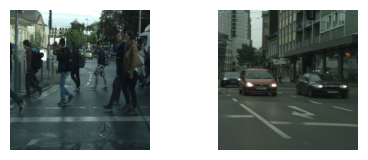

tensor(31, device='cuda:0')


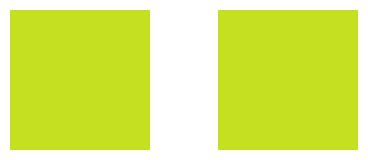

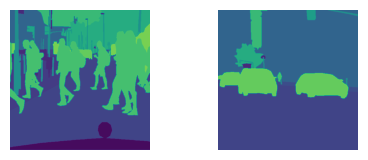

In [18]:
imshow_test(model, train_loader, device, show_reference=True, show_original=True, colorbar=False, softmax=True)

In [19]:
print(device)
libs.test(val_loader, model, loss_fn, device=device, log=True)

cuda


  0%|          | 0/250 [00:00<?, ?it/s]


AssertionError: 

In [ ]:
torch.cuda.empty_cache()


 =============== Epoch 1 ===============


101it [14:49,  8.81s/it]                         


 Train accuracy: 6.743663549423218%, Avg loss: 0.251999895739299, IOU: 0.03606389800552279 lr: 0.001


100%|██████████| 250/250 [13:15<00:00,  3.18s/it]


 Test accuracy: 4.91861067712307%, Avg loss: 3.52636061000824, IOU: 0.29452601447701454
tensor(1, device='cuda:0')


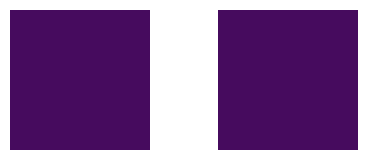

tensor(1, device='cuda:0')


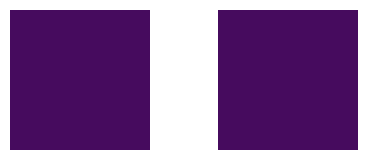


 =============== Epoch 2 ===============


 30%|███       | 30/100 [04:51<11:19,  9.70s/it]


KeyboardInterrupt: 

In [ ]:
for i in range(NUM_EPOCHS//NUM_EPOCHS_TO_SAVE):
    train_(epochs=NUM_EPOCHS_TO_SAVE, inner_log=INNER_LOG_DISPLAY, train_lim=100)
    STORE_PATH = save(os.path.join(str(TRAIN_ID), f'{epoch}'), model, training_accuracy, training_losses, validation_accuracy, validation_losses, lrs)
    plot(STORE_PATH)
    imshow_test(model, val_loader, device, show_reference=False, show_original=False, colorbar=False, softmax=True)